### https://cloud.tencent.com/developer/article/1922442

In [2]:
setwd('/import/DB/zhang//data')
library(Seurat)

In [3]:
sce = readRDS('OBcell.final.rds')

In [8]:
library(clusterProfiler)
library(org.Hs.eg.db)

In [5]:
DefaultAssay(sce) ='RNA'

In [6]:
table(sce$cellgroup)


 Inter_OB normal_OB  tumor_OB 
     1111       407      1391 

In [10]:
Idents(sce) = 'cellgroup'

In [17]:
sce = subset(sce,idents = c('Inter_OB','tumor_OB'))

In [18]:
DefaultAssay(sce) = 'RNA'

In [19]:
Idents(sce)='cellgroup'
deg=FindMarkers(object = sce, ident.1 = 'tumor_OB',ident.2 = 'Inter_OB',
 min.pct = 0.01, logfc.threshold = 0.01,
 thresh.use = 0.99)
head(deg)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CDKN2A,0.000000e+00,2.1157449,0.965,0.029,0.000000e+00
POSTN,4.761971e-290,-2.4078273,0.068,0.765,9.603942e-286
COL1A2,4.133009e-239,-0.6120358,0.999,0.998,8.335453e-235
CST3,2.332451e-234,-0.8204807,0.941,0.974,4.704088e-230
COL11A1,2.271280e-230,-1.4853971,0.437,0.869,4.580718e-226
VIM,6.723575e-229,-0.6172130,0.995,0.993,1.356011e-224


In [20]:
padj = 0.05
foldChange = 0.25

In [21]:
head(deg,2)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CDKN2A,0.000000e+00,2.115745,0.965,0.029,0.000000e+00
POSTN,4.761971e-290,-2.407827,0.068,0.765,9.603942e-286


In [22]:
deg$group = as.factor(ifelse(deg$p_val_adj < padj & abs(deg$avg_log2FC) >= foldChange, 
                                 ifelse(deg$avg_log2FC> foldChange ,'Up','Down'),'NoSignifi'))
table(deg$group)



     Down NoSignifi        Up 
     1062     11905      2209 

In [23]:
res = deg

In [24]:
library(dplyr)


Attaching package: 'dplyr'


The following object is masked from 'package:AnnotationDbi':

    select


The following objects are masked from 'package:IRanges':

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from 'package:S4Vectors':

    first, intersect, rename, setdiff, setequal, union


The following object is masked from 'package:Biobase':

    combine


The following objects are masked from 'package:BiocGenerics':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [25]:
top_5 <- bind_rows(   
      res %>%
        filter(group == 'Up') %>%
        arrange(p_val_adj, desc(avg_log2FC)) %>%
        head(10),
      res %>%
        filter(group == 'Down') %>%
        arrange(p_val_adj, desc(avg_log2FC)) %>%
        head(10)
    )

In [26]:
library(ggpubr)
library(ggplot2)
    library(dplyr)
    library(ggrepel)
    library(ggplot2)
    library(cowplot)

Warning message:
"package 'ggpubr' was built under R version 4.2.3"
Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.2.3"
Warning message:
"package 'ggrepel' was built under R version 4.2.3"
Warning message:
"package 'cowplot' was built under R version 4.2.3"

Attaching package: 'cowplot'


The following object is masked from 'package:ggpubr':

    get_legend




In [27]:
options(repr.plot.height = 6)

Warning message:
"ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


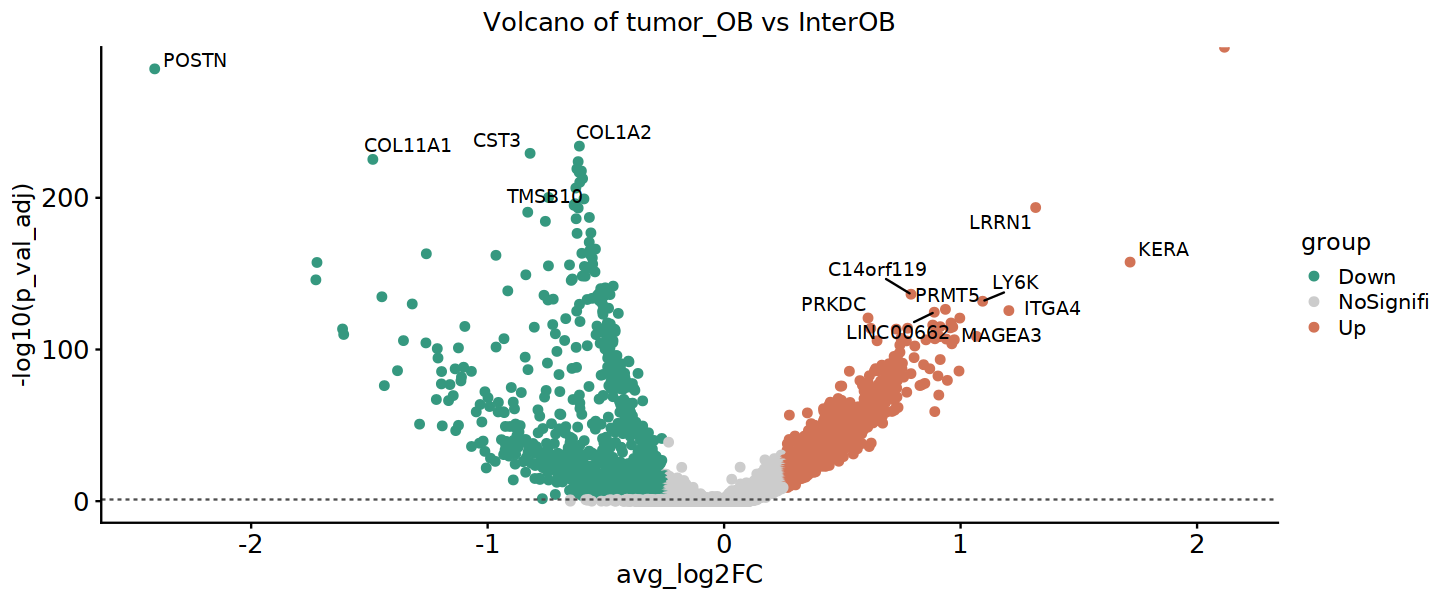

In [38]:

    ggplot(data=res,aes(x=avg_log2FC,y=-log10(p_val_adj)))+
    geom_point(aes(color=group),size=2)+
    geom_hline(yintercept = -log10(0.05), linetype="dashed",color="grey30")+
    #geom_vline(xintercept = c(-.8,.8),linetype="dashed",color="grey30")+
    geom_text_repel(data=top_5,aes(x= avg_log2FC,y= -log10(p_val_adj),label= rownames(top_5)))+
    scale_color_manual(values = c("#35987F","grey80","#D27356"))+
    theme_half_open() +
  theme(axis.title.x = element_text(size = 15))+
  theme(axis.text.x = element_text(size = 15))+
  theme(axis.text.y = element_text(size = 15))+
  theme(plot.title = element_text(size = 15,face = 4, hjust =0.5))+
  ggtitle("Volcano of tumor_OB vs InterOB") 
    ggsave('Volcano.pdf',height = 8,width = 8)
    
   

In [28]:
dim(deg)

[1] 15176     6

In [29]:
diffgene = deg

In [30]:
library(clusterProfiler)
library(enrichplot)
library(org.Mm.eg.db)
#为每个基因添加对应的ENTREZID
diffgene$gene <- rownames(diffgene)
ids=bitr(diffgene$gene,'SYMBOL','ENTREZID','org.Hs.eg.db')
#合并数据，cluser3.markers中没有ENTREZID的基因将被过虑掉
diffgene=merge(diffgene,ids,by.x='gene',by.y='SYMBOL')

head(diffgene)

cluster3.markers = diffgene

#将基因按照avg_log2FC的大小进行降序排列
cluster3.markers <- cluster3.markers[order(cluster3.markers$avg_log2FC,decreasing = T),]
#生成仅含有ENTREZID名字和avg_log2FC值的gene list
cluster3.markers_list <- as.numeric(cluster3.markers$avg_log2FC)
names(cluster3.markers_list) <- cluster3.markers$ENTREZID
head(cluster3.markers_list)

#筛选差异较大的基因集
cluster3_de <- names(cluster3.markers_list)[abs(cluster3.markers_list) > 0.15]
head(cluster3_de)

length(cluster3_de)

Warning message:
"package 'enrichplot' was built under R version 4.2.2"

Attaching package: 'enrichplot'


The following object is masked from 'package:ggpubr':

    color_palette




'select()' returned 1:many mapping between keys and columns

Warning message in bitr(diffgene$gene, "SYMBOL", "ENTREZID", "org.Hs.eg.db"):
"11.56% of input gene IDs are fail to map..."


,gene,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,group,ENTREZID
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1,A1BG,4.184344e-72,0.59346970,0.455,0.104,8.438985e-68,Up,1
2,A1BG-AS1,2.008623e-26,0.26431681,0.125,0.012,4.050990e-22,Up,503538
3,A2M,4.531495e-08,-0.45653838,0.359,0.423,9.139119e-04,Down,2
4,A2M-AS1,6.111995e-08,0.10512970,0.047,0.010,1.232667e-03,NoSignifi,144571
5,A4GALT,1.794536e-21,-0.34900548,0.001,0.068,3.619221e-17,Down,53947
6,AAAS,7.291806e-06,0.06771665,0.269,0.185,1.470611e-01,NoSignifi,8086


1029    11081    57633     3676    54742    51050 
2.115745 1.716735 1.317409 1.204040 1.093247 1.066787

[1] "1029"  "11081" "57633" "3676"  "54742" "51050"

[1] 6117

In [31]:
cluster3_gsekg <- gseKEGG(cluster3.markers_list,organism = "hsa",pvalueCutoff = 0.05)
#将富集结果按照NES绝对值降序排列
cluster3_gsekg_arrange <- arrange(cluster3_gsekg,desc(abs(NES)))
head(cluster3_gsekg_arrange)

Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (0.01% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
"For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation."
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
hsa03010,hsa03010,Ribosome,129,-0.7404960,-3.129060,1e-10,4.8e-09,3.443609e-09,1028,"tags=61%, list=8%, signal=57%",6155/6124/6169/6157/6168/6204/6129/9553/6139/23521/29074/6218/64928/6128/6187/9045/6231/6205/6227/6229/6154/6130/6152/6165/6138/6234/6202/6217/6209/6132/11224/6193/6141/6143/6207/6170/6125/6222/6201/6232/6135/6147/6203/6181/6161/6208/6156/6175/6191/7311/6150/6176/6122/6159/6144/6134/6188/6223/4736/51065/6167/6189/6194/6230/6228/6133/6146/6136/6137/2197/6171/6210/25873/6142/6164/6158/6233/6206/55168
hsa05171,hsa05171,Coronavirus disease - COVID-19,172,-0.6715742,-2.954990,1e-10,4.8e-09,3.443609e-09,1761,"tags=57%, list=13%, signal=50%",6166/6224/115004/3725/5578/6868/5296/5970/9349/6235/6173/6347/6300/2353/4790/23118/1675/3921/6155/6124/6169/6157/6773/629/6168/6204/6129/6139/23521/6218/6128/6187/9045/6231/6205/6227/6229/6154/6130/6152/6165/6138/6234/6202/6217/6209/6132/11224/6193/6141/6143/6207/6170/6125/6222/6201/6232/6135/6147/6203/8829/6181/6161/6208/6156/6175/6191/7311/6176/6122/6159/6144/6134/6188/6223/4736/51065/6167/6189/6194/6230/6228/6133/6146/6136/6137/2197/6171/6210/25873/3576/6142/6164/6158/6233/716/6206/715
hsa04512,hsa04512,ECM-receptor interaction,57,-0.7263836,-2.668349,1e-10,4.8e-09,3.443609e-09,1380,"tags=56%, list=10%, signal=51%",2812/3672/8515/1758/3685/3912/3915/3678/1293/3910/3381/1291/375790/1311/3693/1277/1278/2335/3913/6382/22801/7060/1280/3688/3339/1292/1284/960/1282/7058/7057/6696
hsa04974,hsa04974,Protein digestion and absorption,58,-0.7108921,-2.627430,1e-10,4.8e-09,3.443609e-09,785,"tags=43%, list=6%, signal=41%",2006/1307/4311/50509/1296/1294/81578/1293/1290/1291/7373/1277/1278/1281/1280/1289/1292/1303/80781/1284/1295/1282/1306/1301/1300
hsa04510,hsa04510,Focal adhesion,152,-0.6080554,-2.622580,1e-10,4.8e-09,3.443609e-09,1702,"tags=43%, list=13%, signal=38%",3725/596/5578/87/9475/5296/6464/5908/7791/5499/5500/1398/29780/3672/824/7422/8515/387/5881/3611/5879/3685/7424/3912/3915/330/3082/71/3479/207/3678/572/1293/3910/56034/3381/103910/1291/81/1311/896/3693/1277/1278/60/858/2335/3913/55742/22801/10627/7060/1280/3688/1292/5159/7423/1284/1282/2012/595/7058/857/10398/7057/6696
hsa04820,hsa04820,Cytoskeleton in muscle cells,158,-0.5618484,-2.445852,1e-10,4.8e-09,3.443609e-09,1472,"tags=36%, list=11%, signal=33%",7791/2274/6640/1302/25777/3672/2023/6711/8515/6383/2200/8910/23345/3685/2006/50509/7169/7171/10611/71/3678/1293/1290/64236/1291/375790/8082/1311/4627/1634/3693/1277/1278/7431/60/1465/2335/9260/1281/23500/2192/6382/22801/7060/3688/1289/633/3339/1292/1284/27295/1282/7058/10398/2199/7057/1301


In [32]:
df = cluster3_gsekg_arrange@result

In [33]:
library(ggplot2)
library(ggstatsplot)

Warning message:
"package 'ggstatsplot' was built under R version 4.2.3"
You can cite this package as:
     Patil, I. (2021). Visualizations with statistical details: The 'ggstatsplot' approach.
     Journal of Open Source Software, 6(61), 3167, doi:10.21105/joss.03167



In [36]:
options(repr.plot.width = 12,repr.plot.height = 5)

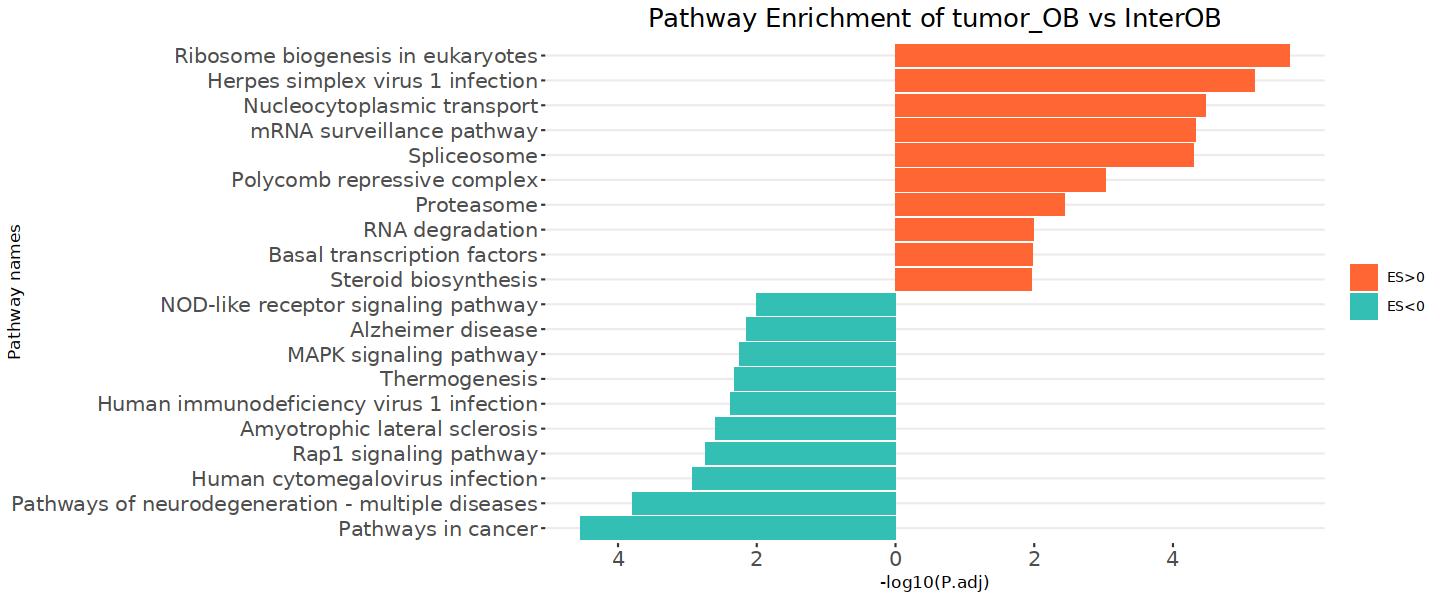

In [39]:
df = df[order(df$enrichmentScore),]
#设定分组：1--ES>0;   -1--ES<0
up = head(subset(df, enrichmentScore>0),10);up$group=1
down = tail(subset(df, enrichmentScore<0),10);down$group=-1
dat=rbind(up,down)
#dat$group = factor(dat$group);str(dat)
dat$pvalue = -log10(dat$pvalue)
dat$pvalue=dat$pvalue*dat$group 
dat=dat[order(dat$pvalue,decreasing = F),]
ggplot(dat, aes(x=reorder(Description,order(pvalue, decreasing = F)), y=pvalue, fill=group)) + 
  geom_bar(stat="identity", aes(fill=factor(group, levels = c(1,-1),  
                                            labels = c("ES>0","ES<0")))) + 
  xlab("Pathway names") +
  ylab("-log10(P.adj)") +
  coord_flip() + 
  theme_ggstatsplot() +
  scale_y_continuous(breaks=c(-4, -2, 0, 2, 4),
                     labels=c("4", "2", "0","2","4")) +
  scale_fill_manual(values = c("#ff6633","#34bfb5")) + 
  theme(plot.title = element_text(size = 15,hjust = 0.5),  
        axis.text = element_text(size = 12,face = 'bold'),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        legend.title = element_blank()) +
  ggtitle("Pathway Enrichment of tumor_OB vs InterOB") 